# Regridding AMSR Unified Data Using `rioxarray`
This notebook describes how to read snow water equivalent derived from AMSR that is part of the AMSR-E/AMSR2 Unified L3 Global Daily 25 km EASE-Grid Snow Water Equivalent, Version 1 dataset.  These data are stored in HDF5 files on the 25 km EASE-Grid.  The data can be read using `xarray` and reprojected using utilities that are part of the `rioxarray` package.

https://nsidc.org/data/AU_DySno/versions/1

In [19]:
from pathlib import Path

import numpy as np
import rioxarray as rio
import xarray as xr

from affine import Affine

In [2]:
filepath = Path.cwd() / 'data' / 'AMSR_U2_L3_DailySnow_B02_20210331.he5'

## Read data
`xarray` can read HDF5 data.  Most HDF data is organised into groups.  You can think of these as directories or folders.  All fields in a group can be read into an `xarray.Dataset` by specifying the group path.  In this case we want to read Northern Hemisphere SWE, which is in the `/HDFEOS/GRIDS/Northern Hemisphere/Data Fields` group.

In [3]:
ds = xr.open_dataset(filepath, group='/HDFEOS/GRIDS/Northern Hemisphere/Data Fields')
ds

<xarray.Dataset>
Dimensions:              (YDim: 721, XDim: 721)
Dimensions without coordinates: YDim, XDim
Data variables:
    Flags_NorthernDaily  (YDim, XDim) float32 ...
    SWE_NorthernDaily    (YDim, XDim) float32 ...

## Add projection and gridtransform information
The data are on an EASE-Grid, which is a Lambert Azimuthal projection.  This information is not included in the HDF file attributes for the data so we have to assign the projection information.  Projection information is given in the "Spatial Information" section of the User Guide linked above.

We can use the EPSG code from Table 3 Geolocation Details to define the CRS (Coordinate Reference System).  `rioxarray` then uses the EPSG code to assign CRS information to the `spatial_ref` attribute in the form of Well-Known-Text (WKT).

In [4]:
ds.rio.write_crs(3408, inplace=True)
ds.spatial_ref

<xarray.DataArray 'spatial_ref' ()>
array(0)
Coordinates:
    spatial_ref  int64 0
Attributes:
    crs_wkt:                         PROJCS["WGS 84 / NSIDC EASE-Grid 2.0 Nor...
    semi_major_axis:                 6378137.0
    semi_minor_axis:                 6356752.314245179
    inverse_flattening:              298.257223563
    reference_ellipsoid_name:        WGS 84
    longitude_of_prime_meridian:     0.0
    prime_meridian_name:             Greenwich
    geographic_crs_name:             WGS 84
    horizontal_datum_name:           World Geodetic System 1984
    projected_crs_name:              WGS 84 / NSIDC EASE-Grid 2.0 North
    grid_mapping_name:               lambert_azimuthal_equal_area
    latitude_of_projection_origin:   90.0
    longitude_of_projection_origin:  0.0
    false_easting:                   0.0
    false_northing:                  0.0
    spatial_ref:                     PROJCS["WGS 84 / NSIDC EASE-Grid 2.0 Nor...

## Assign a GeoTransform to the Dataset
The Dataset has dimensions `XDim` and `YDim` but no coordinates.  To reproject the Dataset, `rioxarray` needs either coordinates or a transform.  This information defines where the data are on the projected map.

The easiest way to define a transform is by defining an Affine matrix.  This is a matrix that contains projected coordinates of the upper left pixel and the pixel size.  From table 4 we find
```
ulxmap: -9036843.073845
ulymap: 9036843.073845
cell_width: 25000.
cell_height: 25000.
```

In [5]:
transform = Affine(25000.0, 0.0, -9036843.073845, 0.0, -25000.0, 9036843.073845)
ds.rio.write_transform(transform, inplace=True)
ds.rio.transform()

Affine(25000.0, 0.0, -9036843.073845,
       0.0, -25000.0, 9036843.073845)

We can also use the transform to assign projected coordinates to the dataset

In [6]:
ds = ds.rename_dims({'XDim': 'x', 'YDim': 'y'})  # Rename dimensions
ds = ds.assign_coords({
    'x': [(transform * (col, 0))[0] for col in ds.x.values],
    'y': [(transform * (col, 0))[0] for col in ds.y.values]
    })

In [7]:
ds

<xarray.Dataset>
Dimensions:              (y: 721, x: 721)
Coordinates:
    spatial_ref          int64 0
  * x                    (x) float64 -9.037e+06 -9.012e+06 ... 8.963e+06
  * y                    (y) float64 -9.037e+06 -9.012e+06 ... 8.963e+06
Data variables:
    Flags_NorthernDaily  (y, x) float32 ...
    SWE_NorthernDaily    (y, x) float32 ...

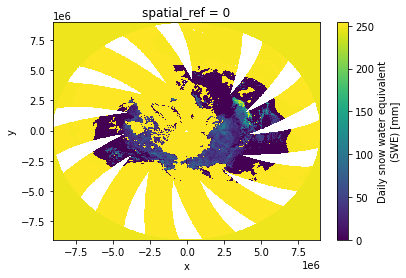

In [9]:
ds.SWE_NorthernDaily.plot()

## Mask data using flags
The SWE fields contain flags and need to be masked.  We can use the `where` method and mask all values less than 242. See User Guide.

In [17]:
ds.SWE_NorthernDaily.attrs

{'coordinates': 'lon lat',
 'long_name': 'Daily snow water equivalent (SWE)',
 'packing_convention': 'netCDF',
 'packing_convention_description': 'unpacked = scale_factor x packed + add_offset',
 'comment': 'Values: 0-240 -- (SWE divided by 2 (mm)), 247 -- Incorrect spacecraft attitude, 248 -- Off-earth, 252 -- Land or snow impossible, 253 -- Ice sheet, 254 -- Water, 255 -- missing value',
 'units': 'mm',
 'format': 'f3.0'}

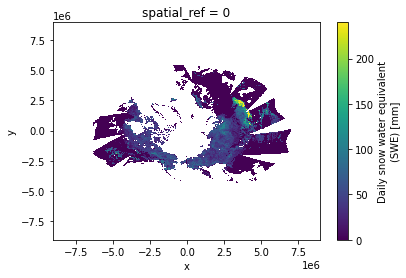

In [20]:
da = ds.SWE_NorthernDaily.where(ds.Flags_NorthernDaily < 242)
da.rio.write_nodata(np.nan)
da.plot()

In [27]:
da

<xarray.DataArray 'SWE_NorthernDaily' (y: 721, x: 721)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
    spatial_ref  int64 0
  * x            (x) float64 -9.037e+06 -9.012e+06 ... 8.938e+06 8.963e+06
  * y            (y) float64 -9.037e+06 -9.012e+06 ... 8.938e+06 8.963e+06
Attributes:
    coordinates:                     lon lat
    long_name:                       Daily snow water equivalent (SWE)
    packing_convention:              netCDF
    packing_convention_description:  unpacked = scale_factor x packed + add_o...
    comment:                         Values: 0-240 -- (SWE divided by 2 (mm))...
    units:                           mm
    format:                          f3.0

## Reproject to lat-lon grid
The data can be reprojected using `reproject`.

__This works - data in correct place - but values are 

In [23]:
da_lonlat = da.rio.reproject("EPSG:4326")

In [24]:
da_lonlat

<xarray.DataArray 'SWE_NorthernDaily' (y: 456, x: 912)>
array([[          nan,           nan,           nan, ...,           nan,
                  nan,           nan],
       [          nan,           nan,           nan, ...,           nan,
                  nan,           nan],
       [          nan,           nan,           nan, ...,           nan,
                  nan,           nan],
       ...,
       [3.4028235e+38, 3.4028235e+38, 3.4028235e+38, ..., 3.4028235e+38,
        3.4028235e+38, 3.4028235e+38],
       [3.4028235e+38, 3.4028235e+38, 3.4028235e+38, ..., 3.4028235e+38,
        3.4028235e+38, 3.4028235e+38],
       [3.4028235e+38, 3.4028235e+38, 3.4028235e+38, ..., 3.4028235e+38,
        3.4028235e+38, 3.4028235e+38]], dtype=float32)
Coordinates:
  * x            (x) float64 -179.8 -179.4 -179.0 -178.6 ... 179.0 179.4 179.8
  * y            (y) float64 89.8 89.41 89.01 88.62 ... -89.0 -89.39 -89.79
    spatial_ref  int64 0
Attributes:
    coordinates:                     lon lat
    long_name:                       Daily snow water equivalent (SWE)
    packing_convention:              netCDF
    packing_convention_description:  unpacked = scale_factor x packed + add_o...
    comment:                         Values: 0-240 -- (SWE divided by 2 (mm))...
    units:                           mm
    format:                          f3.0
    _FillValue:                      3.402823466e+38

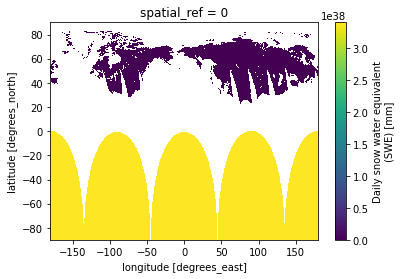

In [25]:
da_lonlat.plot()